In [2]:
import numpy as np
import cv2
import dlib
import time
import sys
import typing as tp
from abc import abstractmethod
import matplotlib.pyplot as plt
from threading import Thread
from queue import Queue

%matplotlib inline

In [3]:
class VideoStream:
    """
    Abstract class fro video streaming
    """
    def __init__(self, src: tp.Union[str, int], name: str) -> None:
        self.stream = cv2.VideoCapture(src)
        self.name: str = name
        self.stopped: bool = False
        self.thread = Thread(target=self.update, name=self.name, args=())
        self.thread.daemon = True

    @abstractmethod
    def start(self) -> "VideoStream":
        pass

    @abstractmethod
    def update(self) -> None:
        pass

    @abstractmethod
    def read(self) -> np.ndarray:
        pass

    @abstractmethod
    def stop(self) -> None:
        pass

    @abstractmethod
    def running(self) -> bool:
        pass


class WebcamVideoStream(VideoStream):
    def __init__(self, src: tp.Union[str, int] = 0, name: str = "WebcamVideoStream") -> None:
        super().__init__(src, name)
        _, self.frame = self.stream.read()

    def start(self) -> VideoStream:
        self.thread.start()
        return self

    def update(self) -> None:
        while True:
            if self.stopped:
                return
            _, self.frame = self.stream.read()

    def read(self) -> np.ndarray:
        return self.frame

    def running(self) -> bool:
        return not self.stopped

    def stop(self) -> None:
        self.stopped = True
        self.stream.release()


class FileVideoStream(VideoStream):
    def __init__(self, src: tp.Union[str, int], name="VideoFile", queue_size=128) -> None:
        super().__init__(src, name)
        self.frames_queue = Queue(maxsize=queue_size)

    def start(self) -> VideoStream:
        self.thread.start()
        return self

    def update(self) -> None:
        while not self.stopped:
            if not self.frames_queue.full():
                is_grabbed, frame = self.stream.read()
                if not is_grabbed:
                    self.stopped = True
                else:
                    self.frames_queue.put(frame)
            else:
                time.sleep(0.1)  # Rest for 10ms, we have a full queue

    def read(self) -> np.ndarray:
        return self.frames_queue.get()

    def running(self) -> bool:
        return self.more() or not self.stopped

    def more(self) -> bool:
        tries = 0
        while self.frames_queue.qsize() == 0 and not self.stopped and tries < 5:
            time.sleep(0.1)
            tries += 1
        return self.frames_queue.qsize() > 0

    def stop(self) -> None:
        self.stopped = True
        self.stream.release()
        self.thread.join()

In [34]:
class WebcamVideoStream:
    def __init__(self, src=0, name="WebcamVideoStream"):
        self.stream = cv2.VideoCapture(src)
        _, self.frame = self.stream.read()
        self.name = name
        self.stopped = False

    def start(self):
        t = Thread(target=self.update, name=self.name, args=())
        t.daemon = True
        t.start()
        return self

    def update(self):
        while True:
            if self.stopped:
                return
            _, self.frame = self.stream.read()

    def read(self):
        return self.frame

    def stop(self):
        self.stopped = True
        
        
class FileVideoStream:
    def __init__(self, path, queue_size=128):
        self.stream = cv2.VideoCapture(path)
        self.stopped = False

        self.Q = Queue(maxsize=queue_size)
        self.thread = Thread(target=self.update, args=())
        self.thread.daemon = True

    def start(self):
        self.thread.start()
        return self

    def update(self):
        while not self.stopped:
            if not self.Q.full():
                is_grabbed, frame = self.stream.read()
                if not is_grabbed:
                    self.stopped = True
                else:
                    self.Q.put(frame)
            else:
                time.sleep(0.1)  # Rest for 10ms, we have a full queue

    def read(self):
        return self.Q.get()

    def running(self):
        return self.more() or not self.stopped

    def more(self):
        tries = 0
        while self.Q.qsize() == 0 and not self.stopped and tries < 5:
            time.sleep(0.1)
            tries += 1
        return self.Q.qsize() > 0

    def stop(self):
        self.stopped = True
        self.stream.release()
        self.thread.join()

In [6]:
video = WebcamVideoStream()
isinstance(video, WebcamVideoStream)

True

In [ ]:
video = FileVideoStream("video.mp4").start()
time.sleep(2)

while True:
    frame = video.read()
#     try:
#         frame = pes.estimate_pose(frame)
#     except NoDetectedFaces:
#         pass
    cv2.imshow("Frame", frame)
    key = cv2.waitKey(1) & 0xFF
    if key == ord("q") or not video.running():
        cv2.destroyAllWindows()
        video.stop()
        break

In [90]:
class NoDetectedFaces(Exception):
    pass


def resize(image, width=None, height=None, inter=cv2.INTER_AREA):
    dim = None
    (h, w) = image.shape[:2]
    if width is None and height is None:
        return image
    if width is None:
        r = height / float(h)
        dim = (int(w * r), height)
    else:
        r = width / float(w)
        dim = (width, int(h * r))

    resized = cv2.resize(image, dim, interpolation=inter)
    return resized


class PoseEstimator:
    def __init__(self, shape_predictor_path="shape_predictor.dat"):
        self.six_points = [30, 8, 36, 45, 48, 54]
        self.predictor = dlib.shape_predictor(shape_predictor_path)
        self.detector = dlib.get_frontal_face_detector()
        self.dist_coeffs = np.zeros((4,1))  # assuming no radial distortion
        self.model_points = np.array([
                                        [0, 0, 0],             # Nose tip
                                        [0, -330, -65],        # Chin
                                        [-225, 170, -135],     # Left eye left corner
                                        [225, 170, -135],      # Right eye right corner
                                        [-150, -150, -125],    # Left Mouth corner
                                        [150, -150, -125]      # Right mouth corner
                                     ], dtype=float)

        
    def facial_landmark(self, img):
        n = 68  # number of landmark points
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        rects = self.detector(gray, 0)
        
        for (i, rect) in enumerate(rects):
            shape = self.predictor(gray, rect)
            shape = np.array([[shape.part(i).x, shape.part(i).y] for i in range(n)])
            return np.array(shape[self.six_points], dtype=float)
        
        if len(rects) == 0:
            raise NoDetectedFaces

    def estimate_pose(self, img):
        try:
            img = resize(img, width=480)
            
            image_points = self.facial_landmark(img)
            model_points = self.model_points

            for (x, y) in image_points.astype(int):
                cv2.circle(img, (x, y), 3, (0, 0, 255), -1)

            focal_length = img.shape[1]
            center = (img.shape[1] / 2, img.shape[0] / 2)
            camera_matrix = np.array([[focal_length, 0, center[0]], [0, focal_length, center[1]], [0, 0, 1]], dtype=float)

            dist_coeffs = self.dist_coeffs
            (success, rotation_vector, translation_vector) = cv2.solvePnP(model_points, image_points, camera_matrix, dist_coeffs)
            if not success:
                print("solvePnP didn't solve system")
                return

            (nose_end_point2D, jacobian) = cv2.projectPoints(np.array([(0.0, 0.0, 1000.0)]), rotation_vector, translation_vector, camera_matrix, dist_coeffs)
            p1 = (int(image_points[0][0]), int(image_points[0][1]))
            p2 = (int(nose_end_point2D[0][0][0]), int(nose_end_point2D[0][0][1]))

            return cv2.line(img, p1, p2, (0, 255, 0), 2)
        except NoDetectedFaces:
            raise

In [91]:
pes = PoseEstimator()

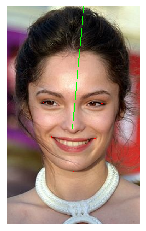

In [92]:
img = cv2.imread("img.jpg")
result = pes.estimate_pose(img)

plt.axis("off")
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB));

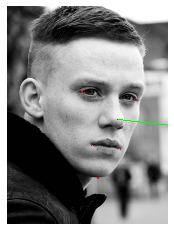

In [93]:
img = cv2.imread("img1.png")
result = pes.estimate_pose(img)

plt.axis("off")
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB));

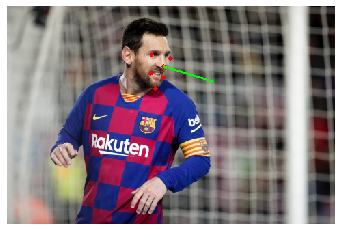

In [94]:
img = cv2.imread("img2.jpeg")
result = pes.estimate_pose(img)

plt.axis("off")
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB));

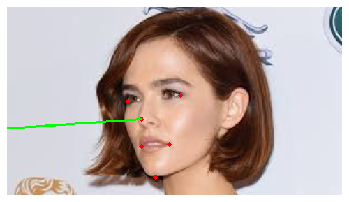

In [95]:
img = cv2.imread("img3.jpeg")
result = pes.estimate_pose(img)

plt.axis("off")
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB));

In [4]:
video = WebcamVideoStream().start()
time.sleep(2)

while True:
    frame = video.read()
#     try:
#         frame = pes.estimate_pose(frame)
#     except NoDetectedFaces:
#         pass
    frame = cv2.flip(frame, 1)  # let's make our camera mirror
    cv2.imshow("Frame", frame)
    key = cv2.waitKey(1) & 0xFF
    if key == ord("q"):
        cv2.destroyAllWindows()
        video.stop()
        break

In [3]:
path_shape_predictor = "shape_predictor.dat"


def rect_to_bb(rect):
    # take a bounding predicted by dlib and convert it
    # to the format (x, y, w, h) as we would normally do
    # with OpenCV
    x = rect.left()
    y = rect.top()
    w = rect.right() - x
    h = rect.bottom() - y
    # return a tuple of (x, y, w, h)
    return (x, y, w, h)

In [4]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(path_shape_predictor)

In [5]:
rects = detector(img_orig, 1)

In [6]:
for (i, rect) in enumerate(rects):
    shape = predictor(img_orig, rect)
    shape = shape_to_np(shape)
    six_points = [30, 8, 36, 45, 48, 54]
    for (x, y) in shape[six_points]:
        cv2.circle(img_orig, (x, y), 2, (0, 0, 255), -1)

# cv2.imshow("Output", img_orig)
# cv2.waitKey(0)

In [7]:
image_points = np.array(shape[six_points], dtype=float)

In [8]:
model_points = np.array([
                            [0, 0, 0],             # Nose tip
                            [0, -330, -65],        # Chin
                            [-225, 170, -135],     # Left eye left corner
                            [225, 170, -135],      # Right eye right corne
                            [-150, -150, -125],    # Left Mouth corner
                            [150, -150, -125]      # Right mouth corner
                        ], dtype=float)
model_points

array([[   0.,    0.,    0.],
       [   0., -330.,  -65.],
       [-225.,  170., -135.],
       [ 225.,  170., -135.],
       [-150., -150., -125.],
       [ 150., -150., -125.]])

In [9]:
focal_length = img_orig.shape[1]
center = (img_orig.shape[1] / 2, img_orig.shape[0] / 2)
camera_matrix = np.array([[focal_length, 0, center[0]], [0, focal_length, center[1]], [0, 0, 1]], dtype=float)

In [10]:
dist_coeffs = np.zeros((4,1))
(success, rotation_vector, translation_vector) = cv2.solvePnP(model_points, image_points, camera_matrix, dist_coeffs)

In [11]:
(nose_end_point2D, jacobian) = cv2.projectPoints(np.array([(0.0, 0.0, 1000.0)]), rotation_vector, translation_vector, camera_matrix, dist_coeffs)

In [12]:
p1 = (int(image_points[0][0]), int(image_points[0][1]))
p2 = (int(nose_end_point2D[0][0][0]), int(nose_end_point2D[0][0][1]))
result = cv2.line(img_orig, p1, p2, (0, 255, 0), 2)

In [13]:
cv2.imshow("Output", result)
cv2.waitKey(0)

27